<a href="https://colab.research.google.com/github/zaidishz/GNN_XAI_Captum/blob/main/GNN_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining GNN Model Predictions using Captum

Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

In [1]:
# Install required packages.
import os
from torch import __version__, tensor
os.environ['TORCH'] = __version__
print(__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import numpy as  np
import itertools

2.0.0+cpu


## Loading the dataset

load the dataset (10% of the data as the test split)

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
import os

proxy = 'http://webproxy:8080'

os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [3]:
achse_mat = scipy.io.loadmat('C:\\Users\\vedurm01\\PycharmProjects\\ZeMA_ML\\ZeMA_Matlab\\Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

C:\Users\vedurm01\PycharmProjects\GNN_XAI_Captum\venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


## Convert time-series data to torch geometric graph data. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute

In [4]:
path = '.'
dataset = []
edge_index_perm = tensor(np.array(list(itertools.combinations(range(1,12), 2))).T)
triu_ind = np.triu_indices(11, k = 1)
for k, sample in enumerate(train_data_reshaped):
    corr_mat = np.corrcoef(sample)
    dataset += [Data(x=sample, edge_index=edge_index_perm, edge_attr= tensor(np.reshape(corr_mat[triu_ind], (55,-1))), y=tensor(train_target_reshaped[k]))]
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

In [5]:
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [7]:
train_dataset[0].y

tensor(11, dtype=torch.uint8)

In [ ]:
plt.plot(train_dataset[0])

## Visualizing the data


In [ ]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


## Sample visualization

We sample a single molecule from train_dataset and visualize it

In [ ]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [13]:
from scipy.fft import fft, fftfreq

In [57]:
T=1/2000.0
N=2000
y = fft(train_data_reshaped[0][1])
xf = fftfreq(N, T)[:N//2]

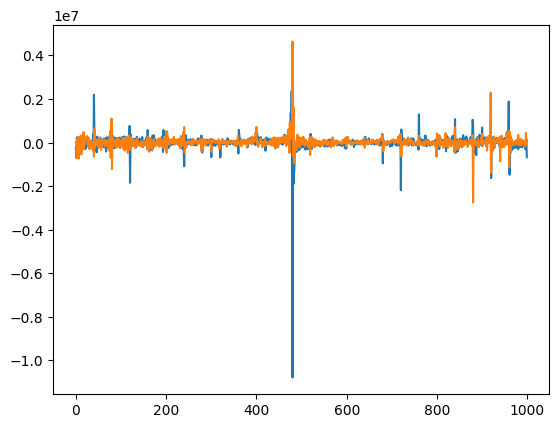

In [58]:
plt.plot(xf, 2.0/N * np.real(y[0:N//2]))
plt.plot(xf, 2.0/N * np.imag(y[0:N//2]))

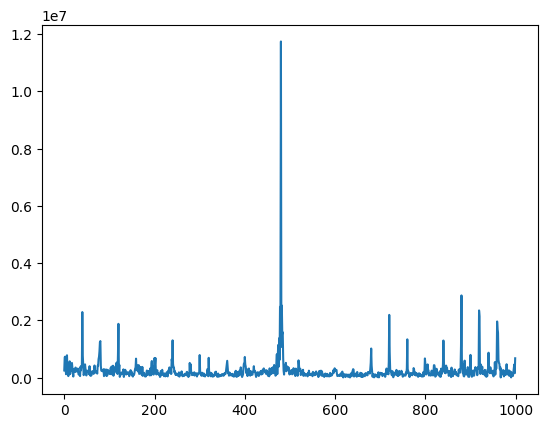

In [59]:
plt.plot(xf, 2.0/N * np.abs(y[0:N//2]))

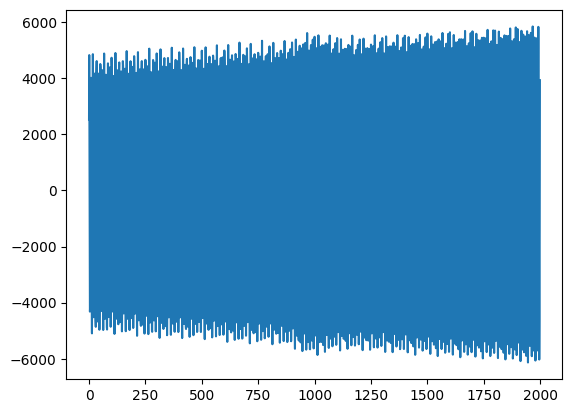

In [52]:
plt.plot(train_data_reshaped[0][10])

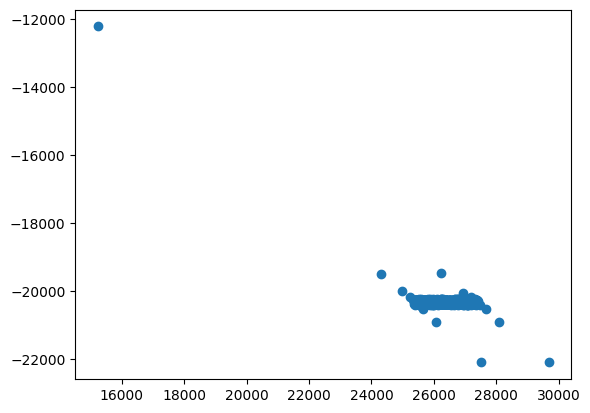

In [56]:
plt.scatter(train_data_reshaped[0][5], train_data_reshaped[0][6])

In [64]:
np.abs(y[0:N//2]).max() / np.abs(y[0:N//2]).min()

3681.260872649384